Plots of the observations, the mask and some histograms based on the observations.      
The interpolation will be performed in notebook [interp_Calanus](interp_Calanus.ipynb).

In [1]:
using CSV
using Dates
using DelimitedFiles 
using NCDatasets
using PyPlot
using DIVAnd
using Statistics
const plt=PyPlot

using PyCall
using PyPlot
colors = PyCall.pyimport("matplotlib.colors")
ccrs = PyCall.pyimport("cartopy.crs")
cfeature = PyCall.pyimport("cartopy.feature")
mticker = PyCall.pyimport("matplotlib.ticker")
coast = cfeature.GSHHSFeature(scale="full");
cartopyticker = PyCall.pyimport("cartopy.mpl.ticker")
lon_formatter = cartopyticker.LongitudeFormatter()
lat_formatter = cartopyticker.LatitudeFormatter()
cmocean = PyCall.pyimport("cmocean")

plt.rc("font", family="Times New Roman", size=16)

## 1. Setting
### 1.1 Colors, domain, projection 

In [2]:
makeplot = true
mycolor = "#6667AB"
mycolor2 = "#456A30" # Green treetop
dom = [-20.5, 11.75, 41.25, 67.]
mainproj = ccrs.Mercator(central_longitude=0.5*(dom[1] + dom[2]),
    min_latitude=dom[3], max_latitude=dom[4])
datacrs = ccrs.PlateCarree()
datacrs

PyObject <Derived Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0.0 +to ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (unknown)
- N[north]: Northing (unknown)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Equidistant Cylindrical
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 1.2 Files and directories

In [3]:
datadir = "../data/"
figdir = "../figures/L05"
resdir = "../results/L05"
resdirm = "../results/monthly/L05"
isdir(datadir) ? @debug("already there") : mkpath(datadir)
isdir(resdir) ? @debug("already there") : mkpath(resdir)
isdir(resdirm) ? @debug("already there") : mkpath(resdirm)
isdir(figdir) ? @debug("already there") : mkpath(figdir)
datafile = joinpath(datadir, "MBA_CPRdata_Emodnet_21Jan22.csv")
isfile(datafile) ? @debug("already downloaded") : download("https://dox.ulg.ac.be/index.php/s/hjWKf1F3C1Pzz1r/download", datafile)
bathfile = joinpath(datadir, "gebco_30sec_16.nc")
isfile(bathfile) ? @debug("already downloaded") : download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download", bathfile)
isfile(datafile), isfile(bathfile)

(true, true)

### 1.3 Grid configuration

In [4]:
Δlon = 0.5
Δlat = 0.5
longrid = dom[1]:Δlon:dom[2]
latgrid = dom[3]:Δlat:dom[4]

41.25:0.5:66.75

## 2. Analysis preparation
### 2.1 Metrics

In [5]:
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);
@info(size(xi));

┌ Info: (65, 52)
└ @ Main In[5]:2


### Prepare mask

In [6]:
bx, by, b = DIVAnd.load_bath(bathfile, true, longrid, latgrid)
@show size(b)

size(b) = (65, 52)


(65, 52)

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


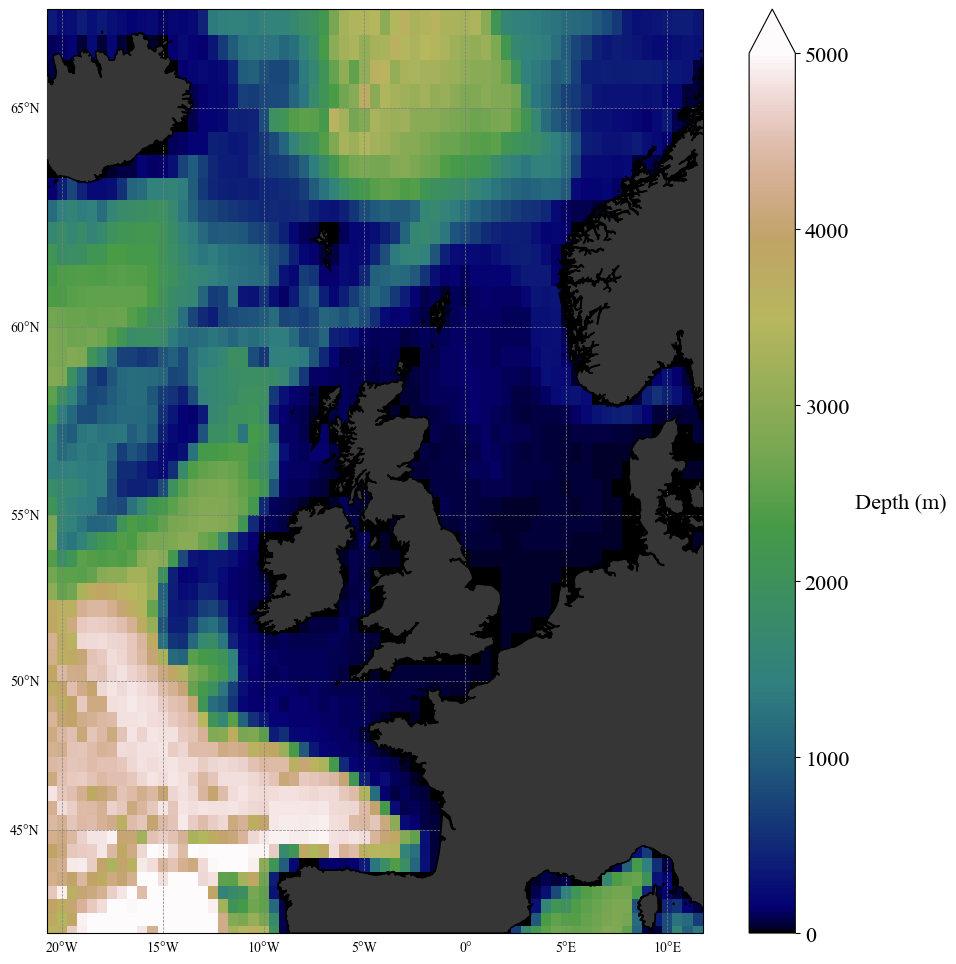

In [11]:
if makeplot
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    pcm = ax.pcolormesh(bx, by, b', vmin=0., vmax=5000., cmap=PyPlot.cm.gist_earth, transform=datacrs);
    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)

    cb = plt.colorbar(pcm, orientation="vertical", extend="max")
    cb.set_label("Depth (m)", rotation=0, ha="left")
    plt.savefig(joinpath(figdir, "domain_bathy_050"), dpi=300, bbox_inches="tight")
    plt.show()
    # plt.close()
end

In [12]:
_, _, mask = DIVAnd.load_mask(bathfile, true, longrid, latgrid, 0.0);
# Remove Mediterranean Sea

# - Resolution = 0.1°
# mask[220:end,1:60] .= 0;

# - Resolution = 0.5°
maskindex = findall((xi .>= 0.) .& (yi .<= 47.))
mask[maskindex] .= 0.;

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


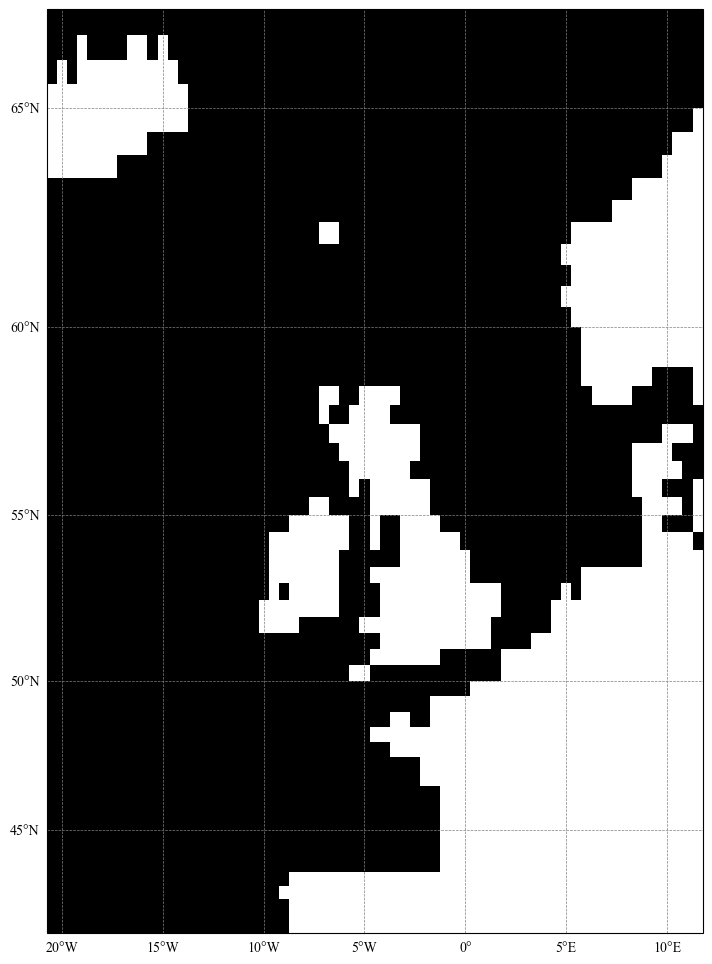

In [14]:
if makeplot

    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    pcm = ax.pcolormesh(bx, by, mask', cmap=PyPlot.cm.binary, transform=datacrs)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
        linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)

    plt.savefig(joinpath(figdir, "domain_mask_050"), dpi=300, bbox_inches="tight")
    plt.show()
end

## Data reading
### Read the CSV files and separate by columns

In [17]:
@time data = readdlm(datafile, ',', skipstart=1);

lon = data[:,3]
lat = data[:,2]
year = data[:,4]
month = data[:,5]
thedates = Date.(year, month)
calanus_finmarchicus = data[:,6]
calanus_helgolandicus = data[:,7];

  0.334365 seconds (3.65 M allocations: 117.691 MiB, 43.34% gc time)


In [13]:
nyears = maximum(year) - minimum(year) + 1
@info(nyears)
yearcount = zeros(nyears);
@info(extrema(year));

┌ Info: 60
└ @ Main In[13]:2
┌ Info: (1959, 2018)
└ @ Main In[13]:4


In [14]:
function count_years_months(year::Array, month::Array)
    
    nyears = maximum(year) - minimum(year) + 1
    @info(nyears)
    yearcount = zeros(nyears)
    monthcount = zeros(12)
    
    ii = 0
    for yyyy in minimum(year):maximum(year)
        ii += 1
        yearcount[ii] = sum(year .== yyyy)
    end
    
    for mm in 1:12
        monthcount[mm] = sum(month .== mm)
    end
       
    return yearcount, monthcount
end

count_years_months (generic function with 1 method)

In [15]:
yearcount, monthcount = count_years_months(year, month);
yearlist = collect(1959:2018)

┌ Info: 60
└ @ Main In[14]:4


In [70]:
arrowdict = Dict("facecolor"=>"k", "width"=>1, "headwidth"=>5)

Dict{String, Any} with 3 entries:
  "facecolor" => "k"
  "width"     => 1
  "headwidth" => 5

### Year histogram

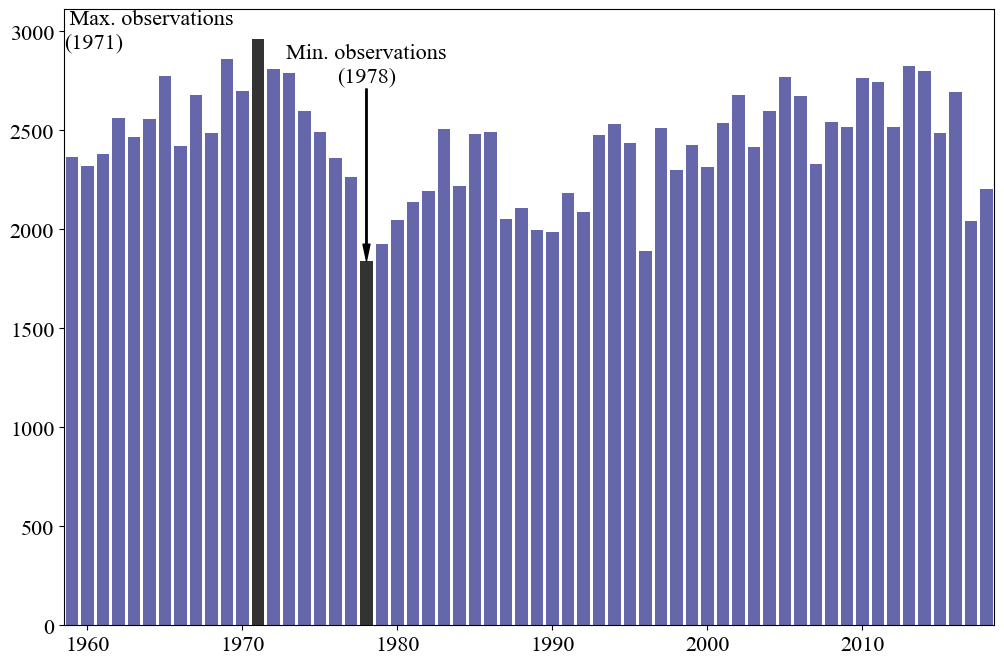

In [75]:
if makeplot

    
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(111)
    ax.set_xlim(yearlist[1] - 0.5, yearlist[end] + 0.5)
    
    
    
    ax.annotate("Min. observations\n($(yearlist[argmin(yearcount)]))", 
        xy=(yearlist[argmin(yearcount)], minimum(yearcount)), 
            xycoords="data",
            xytext=(yearlist[argmin(yearcount)], minimum(yearcount)+ 1100.), textcoords="data",
            arrowprops=arrowdict,
            horizontalalignment="center", verticalalignment="top",
            )
    plt.bar(yearlist[argmin(yearcount)], minimum(yearcount), color=".2", zorder=2)
    
    ax.text(0, 1, " Max. observations\n($(yearlist[argmax(yearcount)]))", 
        transform=ax.transAxes, 
        horizontalalignment="left", verticalalignment="top")
     

    plt.bar(yearlist[argmax(yearcount)], maximum(yearcount), color=".2", zorder=2)
    
    plt.bar(minimum(year):maximum(year), yearcount, color=mycolor)
    plt.savefig(joinpath(figdir, "time_histogram_year"), dpi=300, bbox_inches="tight")
    #plt.show()
    #plt.close()
end

### Month histogram

In [76]:
if makeplot

    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(111)
    plt.bar(1:12, monthcount, color=mycolor)
    ax.set_xticks(collect(1:12), Dates.monthname.(1:12))
    fig.autofmt_xdate()
    plt.savefig(joinpath(figdir, "time_histogram_month"), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
end

### Polar

In [90]:
if makeplot

    N = 12
    theta = LinRange(0, 2 * π - π/6, N)
    width = (1.8 * π) / N
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=true)
    ax.set_thetagrids(collect(0:30:330), Dates.monthname.(1:12))
    ax.set_theta_zero_location("N")
    bars = ax.bar(theta, monthcount, width=width, color=mycolor)
    plt.savefig(joinpath(figdir, "time_histogram_month_polar"), dpi=300, bbox_inches="tight")
    plt.close()
end

## Spatial distribution

In [91]:
if makeplot

    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    ax.plot(lon, lat, "ko", markersize=1, transform=datacrs)
    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    ax.set_title("Locations of the observations")
    plt.savefig(joinpath(figdir, "location_obs"), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
end

### Finmarchicus

In [92]:
if makeplot
    countmin = 5
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    ax.scatter(lon, lat, s=.1, lw=.1, color="k", transform=datacrs)
    indexplot = findall(calanus_finmarchicus .>= countmin)
    scat = ax.scatter(lon[indexplot], lat[indexplot], s=1, c=calanus_finmarchicus[indexplot], 
                      cmap=plt.cm.inferno_r, vmin=countmin, vmax=50., transform=datacrs)

    cb = plt.colorbar(scat, extend="both")

    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    ax.set_title("Calanus_finmarchicus observations")

    plt.savefig(joinpath(figdir, "count_calanus_finmarchicus2.jpg"), dpi=300, bbox_inches="tight")

    plt.show()
end

#### Location of zeros

In [93]:
zerosloc1 = findall(calanus_finmarchicus .== 0.)
lonz1 = lon[zerosloc1]
latz1 = lat[zerosloc1]
zerosloc2 = findall(calanus_helgolandicus .== 0.)
lonz2 = lon[zerosloc2]
latz2 = lat[zerosloc2]

if makeplot

    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    #ax.scatter(0, 0, s=2, lw=.1, alpha=.95, color=mycolor, transform=datacrs, label="0's for Calanus finmarchicus")
    #ax.scatter(0, 0, s=2, lw=.1, alpha=.95, color="#FF9935", transform=datacrs, label="0's for Calanus helgolandicus")
    ax.scatter(lonz1, latz1, s=.5, lw=.1, alpha=.5, color=mycolor, transform=datacrs)
    #ax.scatter(lonz2, latz2, s=.5, lw=.1, alpha=.5, color="#FF9935", transform=datacrs)
    #ax.legend()

    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    ax.set_title("Zeros for Calanus finmarchicus")

    plt.savefig(joinpath(figdir, "zeros_calanus_finmarchicus3.jpg"), dpi=300, bbox_inches="tight")

    plt.close()

    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    ax.scatter(lonz2, latz2, s=.5, lw=.1, alpha=.5, color=mycolor, transform=datacrs)

    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    ax.set_title("Zeros for Calanus helgolandicus")

    plt.savefig(joinpath(figdir, "zeros_calanus_helgolandicus3.jpg"), dpi=300, bbox_inches="tight")

    plt.show()
end

In [94]:
length(lonz1)/length(lon), length(latz2)/length(lat)

(0.7259951559271474, 0.6285184526334515)

#### Calanus helgolandicus

In [95]:
if makeplot

    countmin = 5
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)

    ax.scatter(lon[calanus_helgolandicus .> 0], lat[calanus_helgolandicus .> 0], 
        s=.1, lw=.1, color="k", transform=datacrs)
    indexplot = findall(calanus_helgolandicus .>= countmin)
    scat = ax.scatter(lon[indexplot], lat[indexplot], s=1, c=calanus_helgolandicus[indexplot], 
                      cmap=plt.cm.inferno_r, vmin=countmin, vmax=50., transform=datacrs)

    cb = plt.colorbar(scat, extend="both")

    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    ax.set_title("Calanus helgolandicus observations")

    plt.savefig(joinpath(figdir, "count_calanus_helgolandicus2.jpg"), dpi=300, bbox_inches="tight")

    plt.close()
end